# Notebook 2: Quantifying an image from Listmode data.

In this notebook we will use Python functions to:
- Use the iQID histogram and offsets data to identify issues with acquisition.
- Use the iQID histogram to quantify the activity in an image.
- Apply a decay correction to the time of sample acquisition.

## Import packages

First, move your working directory upwards one so you can access source code in iqid/. This step is necessary because I haven't set up iqid as an installable package (i.e. via pip or conda), reflecting the fact that it's pretty informal and (permanently) in development.

In [1]:
cd ..

/Users/rpeter/Documents/iqid-alphas


In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

%load_ext autoreload
%autoreload 2
from iqid import helper as iq # helper functions such as plotting parameters and other things
from iqid import process_object as po # class to handle listmode data is contained here.

pltmap = iq.set_plot_parms() # set default plot settings (feel free to change this)

# Load data
- Follows the procedure outlined in Demo Notebook 1.

In [3]:
%%time

# enter the path to your iQID data on your machine
datdir = os.path.join(os.getcwd(), r"data_sample", r"File_Structure_Sample")
fname = iq.natural_sort(glob.glob(os.path.join(datdir, "Listmode", "*Compressed_Processed_Listmode.dat")))[-1]
cdat = po.ClusterData(fname, ftype="processed_lm", c_area_thresh=1)
cim = cdat.image_from_big_listmode(event_fx=1)

CPU times: user 2.46 s, sys: 321 ms, total: 2.78 s
Wall time: 2.85 s


# Assess the time histogram
- iQID produces an image, but that image is comprised of many detected radiation events over the course of acquisition.
- The time of each of these event detections is recorded in addition to its position in the Listmode data.
- This is the source of our quantitative activity measurement.

We ultimately want to know:

1. What is the **activity** at the **moment the sample was collected** from the animal?

To evaluate this, we need to know:

2. What is the **time of sample collection** (recorded during the experiment), and 
3. What is the **activity** at the **time of iQID acquisition?**

Then, we can combine (2) and (3) with a simple decay correction to obtain (1). We will now look at how to obtain (3).


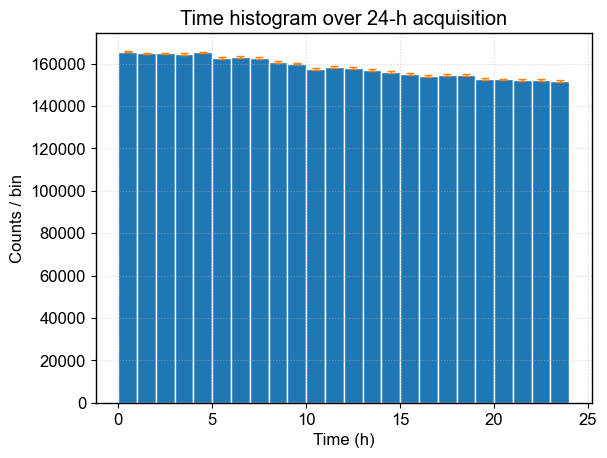

In [4]:
# regardless of what time unit you decide to use, make sure it's consistent for all arrays
thalf = 9.9 * 24 # time 
tdata = cdat.t_s / 60 / 60 # timestamps of each recorded event in hours
t_binsize = 1 # 1-hour binsize -- adjust if needed
nbins = int(np.round((tdata[-1] - tdata[0])/t_binsize))

# generate histogram
n, bins, _ = plt.hist(tdata, bins=nbins, edgecolor='white')
binedges = 0.5 * (bins[1:] + bins[:-1])

# plot the components on top of the histogram
plt.errorbar(binedges, n, np.sqrt(n), linestyle='none', capsize=3) # errorbars
plt.xlabel('Time (h)')
plt.ylabel('Counts / bin')
plt.title('Time histogram over 24-h acquisition')
plt.show()

Since the isotope decays over the course of the acquisition, the rate of event collection goes down over time. Therefore, to define (3), we need to fit the decay over the acquisition to an exponential with the half-life of the known isotope. The **y-intercept**, which is the counts per bin at time t=0 (according to iQID acquisition), is related to the activity at the start of acquisition.

### Fit the histogram with exponential decay

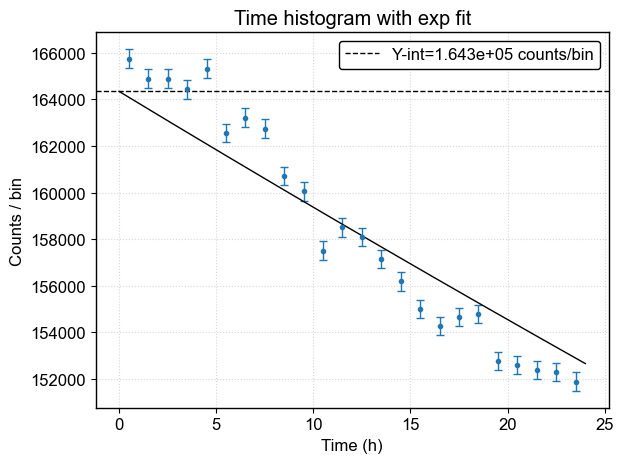

In [5]:
# fit the histogram with an exponential decay
popt, pcov, param_std, res, chisq, chisqn = cdat.fitHist(
    binedges, n, func=po.exponential, p0=[1, thalf], tol=0.05)

# generate dummy array to plot the exponential
tdummy = np.linspace(tdata[0], tdata[-1], 5000)

# plot the components on top of the histogram
plt.errorbar(binedges, n, np.sqrt(n), linestyle='none', capsize=3, marker='.') # errorbars
plt.plot(tdummy, po.exponential(tdummy, *popt), color='k')

# identify the y-intercept and plot it
yint = popt[0]
plt.axhline(yint, color='k', ls='--', label='Y-int={:.3e} counts/bin'.format(yint))

plt.xlabel('Time (h)')
plt.ylabel('Counts / bin')
plt.title('Time histogram with exp fit')
plt.legend()
plt.tight_layout()
plt.show()

### Correct the y-intercept for the binsize

<div class="alert alert-block alert-warning">
<b>Warning:</b> The actual values of the histogram, and the y-intercept, </b>will be different depending on the bin size that you select.</b> Therefore, when calculating the signal in counts per second (to convert to activity), we must <b> correct for the bin size.</b>
</div>

In [6]:
# cps = counts per second = counts / bin * bin / h * h / 3600 s
cps = yint / t_binsize / 3600 

# Use an iQID calibration to convert from cps to activity (Bq or Ci)
- todo

# Apply decay correction to time of sample collection
- todo